In [190]:
import sql_tools 
import pypyodbc
import pandas as pd
import numpy as np
import ryan_tools as rt
import seaborn as sea
import sqlite3
from datetime import datetime, timedelta
from IPython.display import display,Markdown, HTML
from matplotlib import pyplot as plt
phi = (1 + np.sqrt(5))/2

fire = sql_tools.IcePick(sqlite3, 'fire.db')

def printmd(text):
    if type(text) == pd.DataFrame:
        display(HTML(text.to_html()))
        return
    display(Markdown(text))

In [314]:
data =fire.get_data("ETH-USD")
data.set_index('trade_id', inplace = True)
data['time'] = pd.to_datetime(data['time'])

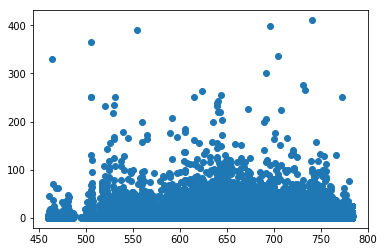

In [377]:
plt.scatter(data['price'], data['last_size'])
plt.show()

In [372]:
x = data.groupby(['side', 'price'])[['dollars']].sum()
x = x.reset_index()
mask = x['side'] == 'sell'
x.loc[mask,'dollars'] = x.loc[mask, 'dollars'] * -1
x.set_index('price', inplace = True)

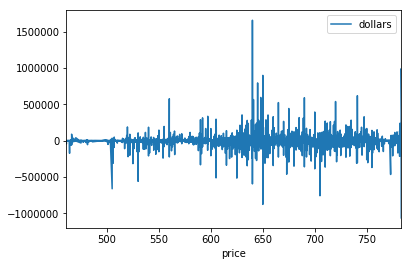

In [373]:
x.plot()
plt.show()

In [321]:
data['dollars'] = data['price'] * data['last_size']
data['dollars'] / data['last_size'].sum()

trade_id
22845245    0.001099
22845246    0.001075
22845247    0.034995
22845248    0.008886
22845249    0.000006
22845250    0.024980
22845251    0.000196
22845252    0.020997
22845253    0.000006
22845254    0.026342
22845256    0.013723
22845257    0.026939
22845259    0.000280
22845260    0.070091
22845265    0.003781
22845266    0.000943
22845268    0.012777
22845269    0.000004
22845270    0.000112
22845271    0.000112
22845272    0.002422
22845273    0.013720
22845274    0.022103
22845275    0.000195
22845276    0.001315
22845277    0.000269
22845278    0.000713
22845279    0.000993
22845280    0.000287
22845281    0.000106
              ...   
23069858    0.000016
23069862    0.000140
23069874    0.002082
23069875    0.007727
23069909    0.013982
23069928    0.005660
23069929    0.013011
23069932    0.000023
23069939    0.000002
23069941    0.005523
23069964    0.000082
23069966    0.000229
23069975    0.000518
23069979    0.000221
23069982    0.001302
23069983    0.002202
2306

In [232]:
def to_candles(data):
    
    data['minutes'] =  (pd.to_datetime(data['time'].dt.strftime('%Y-%m-%d %H:%M')))
    candles = pd.DataFrame(index = set(data['minutes']))
    grouped = data.groupby('minutes')
    candles['low'] = grouped['price'].min()
    candles['high'] = grouped['price'].max()
    candles['25'] = grouped['price'].quantile(0.25)
    candles['75'] = grouped['price'].quantile(0.75)
    candles['median'] = grouped['price'].median()
    grouped = data.groupby(['minutes', 'side'])
    
    candles['sell_volume'] = grouped['last_size'].sum().swaplevel()['sell']
    candles['buy_volume'] = grouped['last_size'].sum().swaplevel()['buy']
    
    candles['sell_mean'] = grouped['price'].mean().swaplevel()['sell']
    candles['buy_mean'] = grouped['price'].mean().swaplevel()['buy']
    
    candles['open'] = data.loc[data.groupby('minutes')['time'].transform(lambda x: x.idxmin())].groupby('minutes')['price'].mean()
    candles['close'] = data.loc[data.groupby('minutes')['time'].transform(lambda x: x.idxmax())].groupby('minutes')['price'].mean()
    candles = candles.sort_index()
    return candles

x = to_candles(data.copy())

In [279]:
import matplotlib.patches as patches

def add_rect(x1, y1, width, height, filled, ax):
    ax.add_patch(
        patches.Rectangle(
            (x1, y1),   # (x,y)
            width,          # width
            height,          # height
            fill = filled
            ))

def chart(candles_in, ax):
    candles = candles_in.copy()
    candles = candles.reset_index()
    
    #plt.plot(candles[['sell_mean', 'buy_mean']])
    for index in candles.index:
        row = candles.loc[index]
        add_rect(index, row['25'], 0.98, row['75'] - row['25'], row['open'] > row['close'] , ax)
        ax.plot([index + 0.5, index + 0.5], [row['low'],row['high']], color = 'grey')
    plt.plot(candles.index + 0.2, candles['open'], '>')
    plt.plot(candles.index + 0.8, candles['close'], '<')

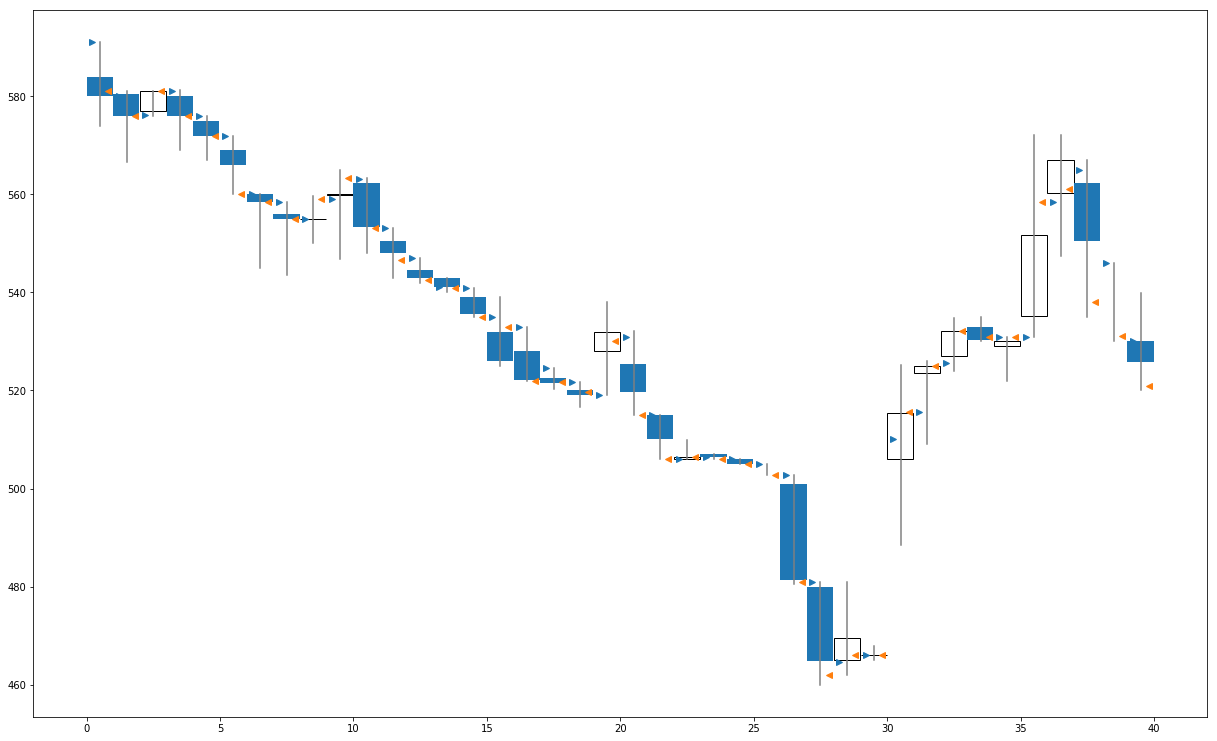

In [289]:
fig, ax = plt.subplots()
fig.set_size_inches(phi * 13, 13)
chart(x[-340:-300],ax)


plt.show()